In [1]:
import sys
import probe as probe

import malariagen_data
import numpy as np
import pandas as pd
import allel

### Creating synthetic relatives to test KING with

- Need to sample across whole genome - recombination breaks should be calculated across chromosomal arms (2l+2r), however, we cannot phase across chromosomal arm boundaries... can we?? and does this matter?
- What to do with the X?
- Do we need a female parent and a male parent?
- Are the X's haploid / homozygous in ag1000g males?

- I need to select parents 
- Each parent has two offspring, store haps and relationship

In [9]:
ag3 = malariagen_data.Ag3()

In [7]:
cohort = 'AG1000G-GH'

In [5]:
snps = ag3.haplotypes(region='2R', sample_sets=cohort, analysis='gamb_colu')
pos = ag3.snp_sites('2R', 'POS').compute()
meta = ag3.sample_metadata(cohort)

Load sample metadata:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
meta = snps['sample_id']

In [7]:
parents = snps['call_genotype'][:,:2, :].compute()

In [2]:
def get_recomb_breakpoints(pos, recomb_rate, verbose=False):
    end = pos[-1]
    arr = np.random.binomial(1, p=10**-8, size=end)
    if arr.sum() > 0:
        idx = np.where(arr)[0]
        print(f"there are {arr.sum()} recombinations") if verbose else []
    else:
        print(f"there are 0 recombinations") if verbose else []
        idx = []
    
    return(idx)

In [9]:
def concat_haplotypes(breaks, parents, parent_idx, end):
    parent_chromosome = np.random.randint(2)
    
    if len(breaks) == 0:
        haplo1 = parents[:, parent_idx, parent_chromosome]
    else:
        haplo1 = np.array([])
        newbreaks = np.concatenate([[0], breaks, [end]])
        breaks = np.concatenate([breaks, [end]])
        for idx, breaks in enumerate(breaks):
            if (idx % 2) == 1:
                parent_chromosome = 1 if parent_chromosome == 0 else 0
            hap = parents[newbreaks[idx]:newbreaks[idx+1], parent_idx, parent_chromosome]
            haplo1 = np.concatenate([haplo1, hap])
    return(haplo1)

In [10]:
def sample_parents_haplotypes(parent1, parent2, pos, recomb_rate, verbose=False):

    parents = parent1.concatenate(parent2, axis=1)

    breaks = get_recomb_breakpoints(pos, recomb_rate, verbose)
    parent_idx = 0
    parent1hap = concat_haplotypes(breaks, parents, parent_idx, pos[-1])
        
    breaks2 = get_recomb_breakpoints(pos, recomb_rate, verbose)
    parent_idx = 1
    parent2hap = concat_haplotypes(breaks2, parents, parent_idx, pos[-1])
    
    offspring_genotypes = allel.GenotypeDaskVector(np.stack([parent1hap, parent2hap], axis=1).astype('i'))
    
    return(offspring_genotypes, breaks, breaks2)

In [270]:
ac_bro = geno_bro.to_haplotypes().count_alleles()
ac_sis = geno_sis.to_haplotypes().count_alleles()

## Testing locally

In [10]:
geno, pos = probe.loadZarrArrays(
    genotypePath="../../resources/snp_genotypes/all/1244-VO-GH-YAWSON-VMF00149/2L/calldata/GT/", 
    positionsPath="../../resources/snp_genotypes/all/sites/2L/variants/POS/", 
    siteFilterPath="../../resources/site_filters/dt_20200416/gamb_colu/2L/variants/filter_pass/")

In [12]:
geno = geno[:10_000_000, :,: ]
pos = pos[:10_000_000]

In [13]:
parents = geno[:,:2,:].compute()

In [2]:
from tqdm import tqdm

def get_recomb_breakpoints(size, recomb_rate, n):
    res = []
    for i in tqdm(range(n)):
        arr = np.random.binomial(1, p=10**-8, size=size)
        #print(f"there are {arr.sum()} recombinations")
        res.append(np.sum(arr))
    return(res)

#     if arr.sum() > 0:
#         idx = np.where(arr)[0]
#         print(f"there are {arr.sum()} recombinations") 
#     else:
#         print(f"there are 0 recombinations") if verbose else []
# #         idx = []
    
#     return(idx)

In [3]:
res = get_recomb_breakpoints(110904205, recomb_rate=10**-8, n=1000)

100%|███████████████████████████████████████| 1000/1000 [37:33<00:00,  2.25s/it]


<AxesSubplot:>

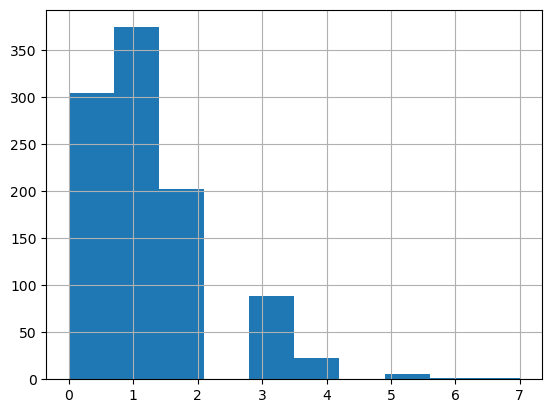

In [28]:
pd.Series(res).hist()

In [11]:
np.equal(res, 0).sum()/np.array(res).shape

array([0.304])

In [24]:
np.log2(np.array(res)+1)

array([1.        , 0.        , 2.        , 1.        , 0.        ,
       2.32192809, 1.        , 1.5849625 , 1.        , 2.        ,
       0.        , 1.        , 1.5849625 , 1.        , 1.5849625 ,
       1.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 1.        , 1.        ,
       1.        , 0.        , 1.        , 2.        , 2.        ,
       1.        , 0.        , 1.5849625 , 0.        , 0.        ,
       0.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.        , 1.        , 0.        , 1.5849625 ,
       0.        , 2.        , 1.5849625 , 2.32192809, 1.        ,
       1.        , 1.5849625 , 1.5849625 , 2.        , 2.        ,
       0.        , 0.        , 1.        , 0.        , 1.        ,
       0.        , 1.        , 0.        , 2.        , 1.5849625 ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       1.        , 1.        , 2.        , 0.        , 0.     

<AxesSubplot:>

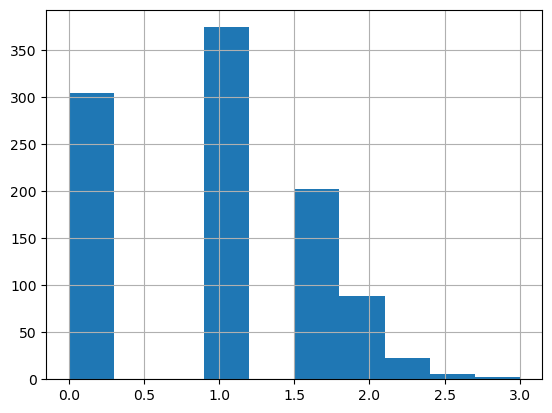

In [25]:
pd.Series(np.log2(np.array(res)+1)).hist()

In [12]:
300/1000

0.3

In [41]:
np.mean(res)

1.114

In [43]:
import scipy 
print(scipy.stats.norm.interval(0.95, loc=np.mean(res), scale=np.std(res)))

(-0.9238008614694497, 3.15180086146945)


In [33]:
(15*100)/60

25.0

In [12]:
pos2 = ag3.snp_sites(region='2R', field="POS").compute()

In [13]:
(pos + pos2[-1])[-1]

110904205

In [ ]:
110904205

In [60]:
np.mean(res)

0.51

In [ ]:
res = get_recomb_breakpoints(110904205, recomb_rate=10**-8, n=1000)
print(np.mean(res))
print(scipy.stats.norm.interval(0.95, loc=np.mean(res), scale=np.std(res)))

there are 0 recombinations
there are 0 recombinations
there are 1 recombinations
there are 1 recombinations
there are 0 recombinations
there are 1 recombinations
there are 2 recombinations
there are 2 recombinations
there are 0 recombinations
there are 2 recombinations
there are 2 recombinations
there are 1 recombinations
there are 1 recombinations
there are 2 recombinations
there are 2 recombinations
there are 0 recombinations
there are 1 recombinations
there are 1 recombinations
there are 0 recombinations
there are 3 recombinations
there are 1 recombinations
there are 1 recombinations
there are 2 recombinations
there are 1 recombinations
there are 0 recombinations
there are 0 recombinations
there are 1 recombinations
there are 2 recombinations
there are 0 recombinations
there are 0 recombinations
there are 0 recombinations
there are 0 recombinations
there are 2 recombinations
there are 1 recombinations
there are 0 recombinations
there are 1 recombinations
there are 2 recombinations
t

In [19]:
np.std(res)

1.1300884921102416

In [24]:
import scipy

In [28]:
scipy.stats.norm.interval(0.95, loc=np.mean(res), scale=np.std(res))

(-0.9849327438792508, 3.4449327438792507)

In [23]:
np.mean(res) + 1.96*np.std(res)

3.444973444536074

In [50]:
parents

<GenotypeArray shape=(10000000, 2, 2) dtype=int8>
0/0 0/0
0/0 0/0
0/0 0/0
...
0/0 0/0
0/0 0/0
0/0 0/0

In [16]:

geno_sis = sample_parents_haplotypes(parents[0], pos=pos, recomb_rate=10**-8)

TypeError: sample_parents_haplotypes() missing 1 required positional argument: 'parent2'

In [221]:


def generationSim(f0_dict, pos, parent_idxs, ind1_idx, ind2_idx, relationship, gen=1):
    f1_dict = {}

    for idx, parent_is in enumerate(parent_idxs):
        f1_dict[f"F1-{idx}-1"], breaks, breaks2 = sample_parents_haplotypes(f0_dict[parent_is[0]],f0_dict[parent_is[1]], pos, 10**-8, verbose=False)
        f1_dict[f"F1-{idx}-2"], breaks, breaks2 = sample_parents_haplotypes(f0_dict[parent_is[0]],f0_dict[parent_is[1]], pos, 10**-8, verbose=False)
        ind1_idx = np.append(ind1_idx, [parent_is, parent_is])
        ind2_idx = np.append(ind2_idx, [f"F1-{idx}-1", f"F1-{idx}-1"])
        ind2_idx = np.append(ind2_idx, [f"F1-{idx}-2", f"F1-{idx}-2"])
        relationship = np.append(relationship, ['Parent-offspring', 'Parent-offspring'])

    f1_parents = np.array(list(f1_dict.keys()))
    f1_1 = f1_parents[pd.Series(f1_parents).str.endswith("-1")]
    f1_2 = f1_parents[pd.Series(f1_parents).str.endswith("-2")]
    f1_1 = f1_1[np.random.choice(f1_1.shape[0], f1_1.shape[0], replace=False)]
    f1_2 = f1_2[np.random.choice(f1_2.shape[0], f1_2.shape[0], replace=False)]
    f1_parents = np.concatenate([f1_1, f1_2]).reshape(32,2)
    
    return(f1_dict, f1_parents, ind1_idx, ind2_idx, relationship)

In [223]:
metadata = pd.read_csv("../../config/metadata.tsv", sep="\t", index_col=0)
parent_idxs = np.random.choice(metadata.shape[0], 64)
parent_idxs = parent_idxs.reshape(int(len(parent_idxs)/2), 2)
geno = geno[:1_000_000, :, :]
pos = pos[:1_000_000]

In [225]:
ind1_idx = np.array([])
ind2_idx = np.array([])
relationship = np.array([])
f0_dict = {}

for idx, parent_is in enumerate(parent_idxs):
    f0_dict[f"F0-{idx}-1"] = geno.take([parent_is[0]], axis=1)
    f0_dict[f"F0-{idx}-2"] = geno.take([parent_is[1]], axis=1)

p1s, p2s = np.array([]), np.array([])
for idx, p1 in enumerate(parent_idxs):
    
    p1s = np.append(p1s, [f"F0-{idx}-1"])
    p2s = np.append(p2s, [f"F0-{idx}-2"])
parent_idxs = np.vstack([p1s,p2s]).T


f1_dict, f1_parents, ind1_idx, ind2_idx, relationship = generationSim(f0_dict, pos, parent_idxs, ind1_idx, ind2_idx, relationship)

In [227]:
f1_parents

array([['F1-5-1', 'F1-14-1'],
       ['F1-18-1', 'F1-27-1'],
       ['F1-22-1', 'F1-10-1'],
       ['F1-17-1', 'F1-11-1'],
       ['F1-19-1', 'F1-6-1'],
       ['F1-20-1', 'F1-12-1'],
       ['F1-26-1', 'F1-13-1'],
       ['F1-21-1', 'F1-16-1'],
       ['F1-1-1', 'F1-8-1'],
       ['F1-9-1', 'F1-24-1'],
       ['F1-15-1', 'F1-28-1'],
       ['F1-29-1', 'F1-30-1'],
       ['F1-25-1', 'F1-4-1'],
       ['F1-23-1', 'F1-7-1'],
       ['F1-3-1', 'F1-31-1'],
       ['F1-2-1', 'F1-0-1'],
       ['F1-20-2', 'F1-4-2'],
       ['F1-10-2', 'F1-5-2'],
       ['F1-29-2', 'F1-17-2'],
       ['F1-22-2', 'F1-6-2'],
       ['F1-16-2', 'F1-13-2'],
       ['F1-8-2', 'F1-7-2'],
       ['F1-23-2', 'F1-11-2'],
       ['F1-26-2', 'F1-12-2'],
       ['F1-18-2', 'F1-19-2'],
       ['F1-25-2', 'F1-30-2'],
       ['F1-21-2', 'F1-15-2'],
       ['F1-24-2', 'F1-3-2'],
       ['F1-1-2', 'F1-14-2'],
       ['F1-27-2', 'F1-28-2'],
       ['F1-2-2', 'F1-31-2'],
       ['F1-0-2', 'F1-9-2']], dtype='<U7')

In [166]:
f2_dict, f2_parents, ind1_idx, ind2_idx, relationship = generationSim(f1_dict, pos, f1_parents, ind1_idx, ind2_idx, relationship)

KeyError: 0

In [105]:
f0_dict = {}
f1_dict = {}

for idx, parent_is in enumerate(parent_idxs):

    f0_dict[idx] = geno.take(parent_is, axis=1)

    f1_dict[f"F1-{idx}-1"], breaks, breaks2 = sample_parents_haplotypes(f0_dict[idx], pos, 10**-8, verbose=False)
    f1_dict[f"F1-{idx}-2"], breaks, breaks2 = sample_parents_haplotypes(f0_dict[idx], pos, 10**-8, verbose=False)
    ind1_idx = np.append(ind1_idx, [parent_is, parent_is])
    ind2_idx = np.append(ind2_idx, [f"F1-{idx}-1", f"F1-{idx}-1"])
    ind2_idx = np.append(ind2_idx, [f"F1-{idx}-2", f"F1-{idx}-2"])
    relationship = np.append(relationship, ['Parent-offspring', 'Parent-offspring'])


In [138]:
f1_parents = np.array(list(f1_dict.keys()))

f1_1 = f1_parents[pd.Series(f1_parents).str.endswith("-1")]
f1_2 = f1_parents[pd.Series(f1_parents).str.endswith("-2")]
f1_1 = f1_1[np.random.choice(f1_1.shape[0], f1_1.shape[0], replace=False)]
f1_2 = f1_2[np.random.choice(f1_2.shape[0], f1_2.shape[0], replace=False)]
f1_parents = np.concatenate([f1_1, f1_2]).reshape(32,2)

In [142]:
f1_parents

array([['F1-2-1', 'F1-6-1'],
       ['F1-5-1', 'F1-0-1'],
       ['F1-31-1', 'F1-27-1'],
       ['F1-11-1', 'F1-8-1'],
       ['F1-12-1', 'F1-20-1'],
       ['F1-19-1', 'F1-15-1'],
       ['F1-4-1', 'F1-14-1'],
       ['F1-24-1', 'F1-1-1'],
       ['F1-18-1', 'F1-21-1'],
       ['F1-16-1', 'F1-30-1'],
       ['F1-10-1', 'F1-28-1'],
       ['F1-13-1', 'F1-7-1'],
       ['F1-22-1', 'F1-25-1'],
       ['F1-23-1', 'F1-26-1'],
       ['F1-9-1', 'F1-17-1'],
       ['F1-3-1', 'F1-29-1'],
       ['F1-31-2', 'F1-29-2'],
       ['F1-9-2', 'F1-7-2'],
       ['F1-5-2', 'F1-24-2'],
       ['F1-4-2', 'F1-11-2'],
       ['F1-1-2', 'F1-21-2'],
       ['F1-19-2', 'F1-6-2'],
       ['F1-10-2', 'F1-2-2'],
       ['F1-25-2', 'F1-16-2'],
       ['F1-12-2', 'F1-26-2'],
       ['F1-22-2', 'F1-17-2'],
       ['F1-13-2', 'F1-28-2'],
       ['F1-0-2', 'F1-3-2'],
       ['F1-15-2', 'F1-18-2'],
       ['F1-30-2', 'F1-8-2'],
       ['F1-20-2', 'F1-23-2'],
       ['F1-27-2', 'F1-14-2']], dtype='<U7')

In [66]:
for idx, offspring in 

{'0-1': <GenotypeDaskVector shape=(1000000, 2) dtype=int32>,
 '0-2': <GenotypeDaskVector shape=(1000000, 2) dtype=int32>,
 '1-1': <GenotypeDaskVector shape=(1000000, 2) dtype=int32>,
 '1-2': <GenotypeDaskVector shape=(1000000, 2) dtype=int32>,
 '2-1': <GenotypeDaskVector shape=(1000000, 2) dtype=int32>,
 '2-2': <GenotypeDaskVector shape=(1000000, 2) dtype=int32>,
 '3-1': <GenotypeDaskVector shape=(1000000, 2) dtype=int32>,
 '3-2': <GenotypeDaskVector shape=(1000000, 2) dtype=int32>,
 '4-1': <GenotypeDaskVector shape=(1000000, 2) dtype=int32>,
 '4-2': <GenotypeDaskVector shape=(1000000, 2) dtype=int32>,
 '5-1': <GenotypeDaskVector shape=(1000000, 2) dtype=int32>,
 '5-2': <GenotypeDaskVector shape=(1000000, 2) dtype=int32>,
 '6-1': <GenotypeDaskVector shape=(1000000, 2) dtype=int32>,
 '6-2': <GenotypeDaskVector shape=(1000000, 2) dtype=int32>,
 '7-1': <GenotypeDaskVector shape=(1000000, 2) dtype=int32>,
 '7-2': <GenotypeDaskVector shape=(1000000, 2) dtype=int32>,
 '8-1': <GenotypeDaskVec

Plot Fst in windows

In [281]:
pos = snps['variant_position']
fst, window_spans, nSNPs, =  allel.windowed_hudson_fst(pos.values, ac_bro, ac_sis, size=1000000)
midpoints = np.apply_along_axis(func1d=np.median, axis=1, arr=window_spans)
import seaborn as sns
sns.scatterplot(x=midpoints, y=fst)